# Домашнее задание
Дообучение энкодерных моделей

**Цель:**

В этом задании вы поработаете с энкодерными трансформерными моделями (например, BERT) и дообучите их для решения различных задач обработки естественного языка (NLP).

**Описание / пошаговая инструкция выполнения домашнего задания:**


1. **Обработка данных:**

- В дополнительных материалах к уроку найдите датасет с отзывами о ресторанах (restaurants_reviews.jsonl).
- Разбейте данные на train/val/test, отложив по 15% в test и val. Не забудьте зафиксировать random_state. В качестве целевой переменной возьмите общий отзыв из колонки general.
- Оставьте только отзывы с рейтингом general равным 1, 3 и 5. Для удобства перекодируйте лейблы 1, 3 и 5 в метки 0, 1, 2.


2. **Дообучение энкодерных моделей:**

- Возьмите 3 модели:

    - https://huggingface.co/sberbank-ai/ruBert-base/ или https://huggingface.co/sberbank-ai/ruBert-large/
    - https://huggingface.co/cointegrated/rubert-tiny2
    - https://huggingface.co/google-bert/bert-base-multilingual-cased

- Дообучите каждую модель на train части данных. Обучение прекращайте, когда модель выходит на плато по метрике на валидации.
- Возьмите итоговый чекпоинт (версию, с минимальным loss на валидации) и замерьте качество на test. В качестве метрики используйте accuracy.


3. **Анализ результатов:**

- Составьте таблицу с результатами для каждой модели, включающую:

    - количество эпох до достижения минимального значения loss на валидационной выборке;
    - время, затрачиваемое на одну итерацию обучения;
    - общее время дообучения;

- Проведите анализ полученных результатов и опишите выводы в Markdown в ноутбуке.


In [5]:
import gc, time
import pandas as pd
pd.options.display.max_colwidth = 300

import numpy as np
import torch
from tqdm.auto import tqdm, trange

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from torch.optim import Adam
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 1. Обработка данных

В дополнительных материалах к уроку найдите датасет с отзывами о ресторанах (restaurants_reviews.jsonl)

In [7]:
df = pd.read_json('./data/restaurants_reviews.jsonl', lines=True)
df

,review_id,general,food,interior,service,text
0,0,0,10,10,10,"Вытянули меня сегодня в город и раз уж была в районе Садовой , решила заехать на тартар в Винсент . Теперь могу спокойно жить дальше - отпустило )) Практически в дверях встречают улыбчивые девушки , интересуются наличием вредных привычек и провожают к столику . Ну , сразу скажу , что мне очень..."
1,1,0,9,10,9,"проводили корпоратив на 60 чел. в этот - уже третий раз все было здорово , возможно организаторы объективно восприняли критику от 26.09.2011 ( читайте мой отзыв ) , а возможно и сами поняли что работать надо с душой , лицом к клиенту и поменялись ..... не знаю что произошло , но изменения в лучш..."
2,2,0,9,10,10,"Был в Гостях с женой один раз и еще раз с женой и другом . Очень прикольный интерьер . Официанты очень хорошо обслуживают . Я бы даже сказал виртуозно , обслуживал нас молодой человек ( к сожалению не запомнил как его зовут ) , который буквально порхал с подносом и предугадывал наши вопросы и..."
3,3,0,-,5,10,"Бар понравился на первый взгляд . Интерьер к достоинствам бара я не отнесу , но коктейли интересные , обслуживание доброжелательное , быстрое . Цены средние : практически любой коктейль - 350р , набор из 4х шотов на основе джина ( например ) - 600р . Есть безалкогольные напитки - домашние лим..."
4,4,0,7,10,10,"В « Bel Canto » мы отмечали юбилей моего отца . К сожалению , я опоздал и не застал начало мероприятия . Встретили очень хорошо вежливо и с улыбкой . Сев за стол был приятно удивлен оформлением стола . Официанты молодые люди ( парни ) , что бывает довольно редко . Их было не видно и ни кто ..."
...,...,...,...,...,...,...
47134,47134,0,0,0,0,"Большое спасибо Ирине - за организацию , официантам - за оперативность , аккуратность и улыбчивость и поварам - за мастерство ( все гости отметили вкусно приготовленные блюда - начиная от канапе и заканчивая горячим ) . Все было на высшем уровне . Зал был оформлен очень красиво , отдельное спа..."
47135,47135,0,0,0,0,"В данном заведении мы частые гости и всегда советуем его своим знакомым и друзьям , т. к. в Райском дворике действительно красиво , уютно , а готовят ну просто великолепно . 11 мая 2012г . в 17-00 мы с мужем пришли отметить вдвоем его день рождения в данное заведение Райский дворик . Обслуживал..."
47136,47136,0,0,0,0,"07/05/2012 Отмечали здесь свадьбу и остались очень довольны . Нареканий нет ни к кухне , ни к персоналу , ни к интерьеру . Огромное спасибо управляющей Нине Георгиевне , всему персоналу за организацию нашего праздника . Помогли и советом ( при выборе меню , при рассадке гостей ) и делом , как..."
47137,47137,0,0,0,0,"Были проездом в Москве , заглянули с коллегой в Колбасофф на Павелецкой . Заказали нефильтрованного темного и подкопченные мюнхенские колбаски . От последних аппетитно пахло живым костром . Короче , нам понравилось !"


Оставьте только отзывы с рейтингом general равным 1, 3 и 5.

In [9]:
df[df['general'].isin([1,3,5])]['general'].value_counts()

general
5    2164
1     462
3     150
Name: count, dtype: int64

In [10]:
df[df['general'].isin([1,3,5])]['general'].value_counts().sum()

2776

In [11]:
df = df[df['general'].isin([1,3,5])]
df['general'].value_counts()

general
5    2164
1     462
3     150
Name: count, dtype: int64

Для удобства перекодируйте лейблы 1, 3 и 5 в метки 0, 1, 2.

In [13]:
dict_map = {1:0, 3:1, 5:2}
df['general'] = df['general'].map(dict_map)

In [14]:
df['general'].value_counts()

general
2    2164
0     462
1     150
Name: count, dtype: int64

In [15]:
df['general'].value_counts().sum()

2776

Разбейте данные на train/val/test, отложив по 15% в test и val. Не забудьте зафиксировать random_state. В качестве целевой переменной возьмите общий отзыв из колонки general.

In [17]:
dataset_full = Dataset.from_dict({'text': df.text, 'label': df.general})
dataset_full

Dataset({
    features: ['text', 'label'],
    num_rows: 2776
})

In [18]:
# Split dataset into train and test
train_test_split = dataset_full.train_test_split(test_size=0.15)  ## 15% for test dataset
train_split = train_test_split["train"]
test_dataset = train_test_split["test"]

In [19]:
# Split the training dataset further into train and validation
train_val_split = train_split.train_test_split(test_size=0.176) # 0.176 of the train_dataset is 0.15 of the original dataset
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

In [20]:
# Now we've splitted dataset into train/val/test parts in 70/15/15 proportion from the original one
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['text', 'label'],
     num_rows: 1943
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 416
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 417
 }))

In [21]:
# Create a single DatasetDict for easy access
data = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1943
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 416
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 417
    })
})

In [22]:
## Clearing memory from temporary datasets
del dataset_full, train_test_split, train_split, train_val_split ## train_dataset, val_dataset, test_dataset

In [23]:
data['train'][8]

{'text': 'Очень часто стали стучаться " промахи " поваров .  То котлетки из моркови резиновые , то творог в блинчиках кислый .  Вариантов пообедать у офисных сотрудников нет , вот и приходится терпеть честно говоря не очень достойное творчество поваров данного заведения .  Для некурящих людей посещение кафе превращается в муку .  Почему бы не сделать курящей одну зону - например около входа ( там где окна ) ??? Скорее бы законом запретили курить в ресторанах !  После обеда хочется вымыть голову и постирать костюм , так все попахивает табачищем !  ',
 'label': 1}

## 2. Дообучение энкодерных моделей

- Возьмите 3 модели:

    - https://huggingface.co/sberbank-ai/ruBert-base/ или https://huggingface.co/sberbank-ai/ruBert-large/
    - https://huggingface.co/cointegrated/rubert-tiny2
    - https://huggingface.co/google-bert/bert-base-multilingual-cased

## 2.1 ruBERT-base

In [26]:
base_model = 'ai-forever/ruBert-base'

In [27]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer

BertTokenizerFast(name_or_path='ai-forever/ruBert-base', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [28]:
data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
data_tokenized

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1943
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 416
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 417
    })
})

In [29]:
print(data_tokenized['train'][0])

{'label': 2, 'input_ids': [101, 15819, 2038, 12866, 378, 121, 25985, 30255, 121, 29041, 660, 2102, 378, 8550, 121, 24808, 1553, 50749, 897, 667, 378, 177, 56446, 23486, 647, 1293, 126, 789, 113, 4813, 780, 1308, 7628, 177, 177, 177, 30602, 1613, 1153, 1232, 24453, 4875, 1012, 177, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [30]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [31]:
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True, batch_size=8, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['validation'], shuffle=False, batch_size=8, collate_fn=collator)
test_dataloader = DataLoader(data_tokenized['test'], shuffle=False, batch_size=8, collate_fn=collator)

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=3)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [34]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [35]:
optimizer = Adam(model.parameters(), lr=1e-6)  # with tiny batches, LR should be very small as well
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)

In [36]:
gc.collect()
torch.cuda.empty_cache()

In [37]:
# seting initial best loss to infinite
best_eval_loss = float('inf')

losses = []
epoch_train_loss = []
epoch_eval_loss = []
epoch_train_time = []
train_time = []
start = time.time()
for epoch in trange(20):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(out.loss.item())
        train_time.append(time.time() - start)
        pbar.set_description(f'loss: {np.mean(losses[-100:]):2.2f}')
    epoch_train_loss.append(np.mean(losses[-100:]))

    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    val_time = []
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
        val_time.append(time.time() - start)
    epoch_eval_loss.append(np.mean(eval_losses))
    epoch_train_time.append(elapsed := time.time() - start)
    val_loss = np.mean(eval_losses)
    print('Epoch:', epoch+1, 'Train Loss', np.mean(losses[-100:]), 'Eval Loss', val_loss, 'Accuracy', np.mean(np.array(eval_targets) == eval_preds), 'Time:', elapsed)

    #save the best model
    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        torch.save(model.state_dict(), model.name_or_path.split('/')[1]+'.saved.weights.pt')   

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1 Train Loss 0.6127962258458137 Eval Loss 0.5677023939788342 Accuracy 0.7836538461538461 Time: 16.14020299911499


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2 Train Loss 0.4261140565574169 Eval Loss 0.38369917840911794 Accuracy 0.8605769230769231 Time: 33.800623655319214


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3 Train Loss 0.3395243784040213 Eval Loss 0.3056244347244501 Accuracy 0.90625 Time: 51.940850257873535


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4 Train Loss 0.28344254970550536 Eval Loss 0.2773521670785088 Accuracy 0.9182692307692307 Time: 69.38828444480896


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5 Train Loss 0.26212308209389446 Eval Loss 0.27115621571787274 Accuracy 0.9134615384615384 Time: 86.60622191429138


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6 Train Loss 0.24778847247362137 Eval Loss 0.2623079432747685 Accuracy 0.9182692307692307 Time: 103.79372382164001


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 7 Train Loss 0.2470909897610545 Eval Loss 0.25863084906282335 Accuracy 0.9230769230769231 Time: 121.0922498703003


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 8 Train Loss 0.22055625326931477 Eval Loss 0.25524131079705864 Accuracy 0.9254807692307693 Time: 138.18231654167175


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 9 Train Loss 0.18844507260248064 Eval Loss 0.2482653847322441 Accuracy 0.9278846153846154 Time: 155.3871443271637


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 10 Train Loss 0.20937968000769616 Eval Loss 0.24402534119928113 Accuracy 0.9302884615384616 Time: 172.77925300598145


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 11 Train Loss 0.23724032815545798 Eval Loss 0.2472632801733338 Accuracy 0.9254807692307693 Time: 190.0011875629425


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 12 Train Loss 0.1724500785395503 Eval Loss 0.24151641939981625 Accuracy 0.9206730769230769 Time: 206.32340264320374


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 13 Train Loss 0.1596848546154797 Eval Loss 0.23803226966769075 Accuracy 0.9254807692307693 Time: 223.79809308052063


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 14 Train Loss 0.15589020911604165 Eval Loss 0.2418207094932978 Accuracy 0.9302884615384616 Time: 241.47682285308838


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 15 Train Loss 0.16589688254520296 Eval Loss 0.24641998001159385 Accuracy 0.9254807692307693 Time: 258.1396870613098


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 16 Train Loss 0.12322863028384745 Eval Loss 0.25093501206272495 Accuracy 0.9230769230769231 Time: 274.6096622943878


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 17 Train Loss 0.13441455650143325 Eval Loss 0.2542319572530687 Accuracy 0.9182692307692307 Time: 291.3469285964966


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 18 Train Loss 0.10647006810642778 Eval Loss 0.25635947337230813 Accuracy 0.9182692307692307 Time: 307.9278450012207


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 19 Train Loss 0.12524042496457696 Eval Loss 0.25914665510376483 Accuracy 0.9182692307692307 Time: 324.1705231666565


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 20 Train Loss 0.10616464875638484 Eval Loss 0.27340562655948675 Accuracy 0.9086538461538461 Time: 340.2781422138214


In [38]:
epoch_eval_loss.index(min(epoch_eval_loss)), min(epoch_eval_loss)

(12, 0.23803226966769075)

In [39]:
epoch_train_time[epoch_eval_loss.index(min(epoch_eval_loss))]

223.79809308052063

In [40]:
epoch_train_time[-1]

340.2781422138214

In [41]:
epoch_train_time[-1]/len(epoch_train_time)

17.013907110691072

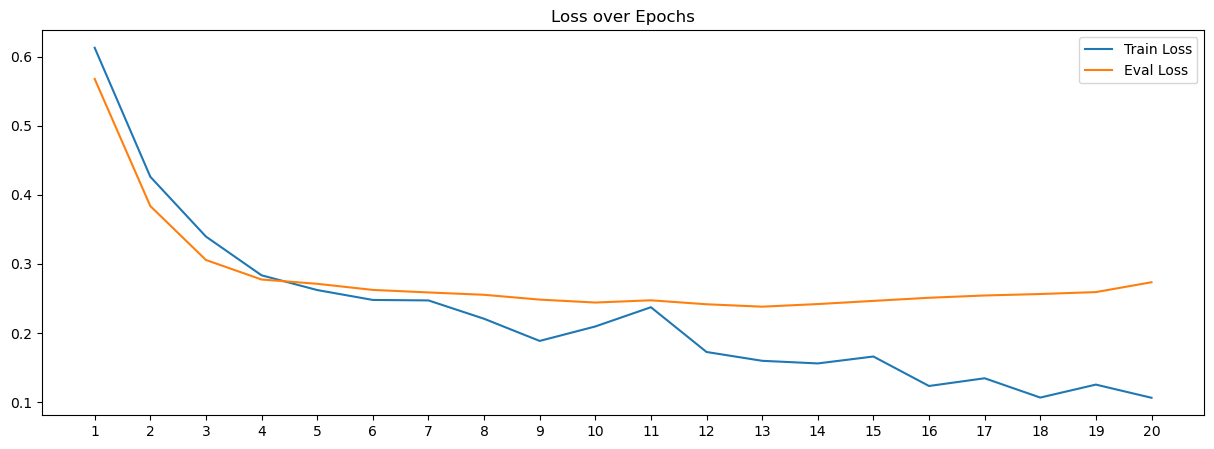

In [42]:
# Plotting training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(np.arange(1, 21, 1), epoch_train_loss, label='Train Loss')
plt.plot(np.arange(1, 21, 1), epoch_eval_loss, label='Eval Loss')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.title('Loss over Epochs')
plt.show();

Загрузим лучшую сохраненную модель

In [44]:
#loading the best saved model
path = model.name_or_path.split('/')[1]+'.saved.weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [45]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [46]:
model.eval()
test_losses = []
test_preds = []
test_targets = []

for batch in tqdm(test_dataloader):
    with torch.no_grad():
            out = model(**batch.to(model.device))
    test_losses.append(out.loss.item())
    test_preds.extend(out.logits.argmax(1).tolist())
    test_targets.extend(batch['labels'].tolist())

print('Eval Loss', np.mean(test_losses), 'Accuracy', np.mean(np.array(test_targets) == test_preds))

  0%|          | 0/53 [00:00<?, ?it/s]

Eval Loss 0.2653041071662644 Accuracy 0.920863309352518


In [47]:
accuracy_score(test_targets, test_preds)

0.920863309352518

In [48]:
confusion_matrix(test_targets, test_preds)

array([[ 54,   5,   8],
       [  8,   6,   6],
       [  3,   3, 324]])

### Создадим процедуру для оценки модели

In [50]:
results = {}

In [51]:
def quality(etime, vloss):
    """
        etime: list of accumulated train time for each epoch;
        vloss: list of validation losses for each epoch;
    """
    # количество эпох до достижения минимального значения loss на валидационной выборке,
    min_epoch_num = vloss.index(min(vloss))
    #общее время дообучения
    total_train_time = etime[min_epoch_num]
    #время, затрачиваемое на одну итерацию обучения
    avg_train_step_time = etime[-1]/len(etime)
    print(f"min_epoch_num: {min_epoch_num+1}, avg_train_step_time: {avg_train_step_time}, total_train_time: {total_train_time} ")
    return [min_epoch_num+1, round(avg_train_step_time, 2), round(total_train_time, 2)]    

In [52]:
def get_model_results(etime, vloss, dataloader, model):
    """
        etime: List of accumulated train time for each epoch;
        vloss: List of validation losses for each epoch;
        dataloader: Dataloader for model; 
        model: Model to test;
    """
    # количество эпох до достижения минимального значения loss на валидационной выборке,
    min_epoch_num = vloss.index(min(vloss))
    #общее время дообучения
    total_train_time = etime[min_epoch_num]
    #время, затрачиваемое на одну итерацию обучения
    avg_train_step_time = etime[-1]/len(etime)

    model.eval()
    test_losses = []
    test_preds = []
    test_targets = []
    
    for batch in tqdm(test_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        test_losses.append(out.loss.item())
        test_preds.extend(out.logits.argmax(1).tolist())
        test_targets.extend(batch['labels'].tolist())
    
    accuracy_metric = np.mean(np.array(test_targets) == test_preds)

    print(f"min_epoch: {min_epoch_num+1}, epoch_time: {avg_train_step_time}, total_train_time: {total_train_time}, accuracy: {accuracy_metric}")
    return [min_epoch_num+1, round(avg_train_step_time, 2), round(total_train_time, 2), round(accuracy_metric,4)]    

In [53]:
quality(epoch_train_time, epoch_eval_loss)

min_epoch_num: 13, avg_train_step_time: 17.013907110691072, total_train_time: 223.79809308052063 


[13, 17.01, 223.8]

In [54]:
get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/53 [00:00<?, ?it/s]

min_epoch: 13, epoch_time: 17.013907110691072, total_train_time: 223.79809308052063, accuracy: 0.920863309352518


[13, 17.01, 223.8, 0.9209]

Сохраним результаты

In [56]:
results['ruBERT-base'] = get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/53 [00:00<?, ?it/s]

min_epoch: 13, epoch_time: 17.013907110691072, total_train_time: 223.79809308052063, accuracy: 0.920863309352518


In [57]:
pd.DataFrame(results, index=['Epoch num','Epoch avg time','Total train time','Accuracy']).T

,Epoch num,Epoch avg time,Total train time,Accuracy
ruBERT-base,13.0,17.01,223.8,0.9209


## 2.2 ruBERT-tiny2

In [59]:
base_model = 'cointegrated/rubert-tiny2'

In [60]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer

BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [61]:
data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
data_tokenized

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1943
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 416
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 417
    })
})

In [62]:
print(data_tokenized['train'][0])

{'label': 2, 'input_ids': [2, 70155, 39888, 16, 47189, 48639, 16, 44629, 548, 21943, 32946, 16, 39149, 19091, 16691, 28456, 9033, 5, 36199, 42626, 1139, 9922, 18, 791, 314, 30579, 2749, 5219, 42668, 3932, 38682, 5, 5, 5, 57529, 2554, 1977, 5081, 37385, 23016, 1614, 5, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [63]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [64]:
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True, batch_size=16, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['validation'], shuffle=False, batch_size=16, collate_fn=collator)
test_dataloader = DataLoader(data_tokenized['test'], shuffle=False, batch_size=16, collate_fn=collator)

In [65]:
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=3)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [66]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [67]:
optimizer = Adam(model.parameters(), lr=1e-5)  # with tiny batches, LR should be very small as well
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [68]:
gc.collect()
torch.cuda.empty_cache()

In [69]:
# seting initial best loss to infinite
best_eval_loss = float('inf')

losses = []
epoch_train_loss = []
epoch_eval_loss = []
epoch_train_time = []
train_time = []
start = time.time()
for epoch in trange(20):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(out.loss.item())
        train_time.append(time.time() - start)
        pbar.set_description(f'loss: {np.mean(losses[-100:]):2.2f}')
    epoch_train_loss.append(np.mean(losses[-100:]))

    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    val_time = []
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
        val_time.append(time.time() - start)
    epoch_eval_loss.append(np.mean(eval_losses))
    epoch_train_time.append(elapsed := time.time() - start)
    val_loss = np.mean(eval_losses)
    print('Epoch:', epoch+1, 'Train Loss', np.mean(losses[-100:]), 'Eval Loss', val_loss, 'Accuracy', np.mean(np.array(eval_targets) == eval_preds), 'Time:', elapsed)

    #save the best model
    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        torch.save(model.state_dict(), model.name_or_path.split('/')[1]+'.saved.weights.pt')   

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 1 Train Loss 0.7151235690712929 Eval Loss 0.5889785071978202 Accuracy 0.7836538461538461 Time: 2.8666391372680664


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 2 Train Loss 0.5253457218408585 Eval Loss 0.42491181882528156 Accuracy 0.8365384615384616 Time: 5.901871919631958


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 3 Train Loss 0.39829072609543803 Eval Loss 0.3380157775603808 Accuracy 0.8870192307692307 Time: 8.991771936416626


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 4 Train Loss 0.34313974492251875 Eval Loss 0.3100672559096263 Accuracy 0.90625 Time: 12.157584428787231


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 5 Train Loss 0.30348045594990253 Eval Loss 0.31267326640395016 Accuracy 0.9014423076923077 Time: 15.231136560440063


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 6 Train Loss 0.2804319966956973 Eval Loss 0.31141822405446035 Accuracy 0.8942307692307693 Time: 18.126221179962158


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 7 Train Loss 0.2626415820047259 Eval Loss 0.30667987795403373 Accuracy 0.9014423076923077 Time: 21.075112104415894


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 8 Train Loss 0.23419097788631915 Eval Loss 0.3114390273650105 Accuracy 0.8966346153846154 Time: 24.332290410995483


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 9 Train Loss 0.21667862689122558 Eval Loss 0.32325351524811524 Accuracy 0.9014423076923077 Time: 27.35080885887146


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 10 Train Loss 0.21398505637422205 Eval Loss 0.32217257971373886 Accuracy 0.8966346153846154 Time: 30.386499404907227


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 11 Train Loss 0.20225079819560052 Eval Loss 0.3331269421256505 Accuracy 0.8918269230769231 Time: 33.2451388835907


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 12 Train Loss 0.1876277345046401 Eval Loss 0.34345384088989633 Accuracy 0.8966346153846154 Time: 36.16288423538208


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 13 Train Loss 0.1736921156011522 Eval Loss 0.35391687555238605 Accuracy 0.8918269230769231 Time: 39.1045355796814


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 14 Train Loss 0.16354881159961224 Eval Loss 0.36327673190344983 Accuracy 0.8894230769230769 Time: 41.9843008518219


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 15 Train Loss 0.14145695017650722 Eval Loss 0.36830625027561414 Accuracy 0.8990384615384616 Time: 44.89818048477173


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 16 Train Loss 0.13322506521828473 Eval Loss 0.3730236471344072 Accuracy 0.8894230769230769 Time: 47.807517766952515


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 17 Train Loss 0.12628945903852581 Eval Loss 0.38630407203275424 Accuracy 0.8918269230769231 Time: 50.72842788696289


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 18 Train Loss 0.11662023358978331 Eval Loss 0.3950802837140285 Accuracy 0.8942307692307693 Time: 53.66117787361145


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 19 Train Loss 0.10066758052445948 Eval Loss 0.3997034876105877 Accuracy 0.8870192307692307 Time: 56.56002402305603


  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch: 20 Train Loss 0.09572998252697289 Eval Loss 0.402700309175998 Accuracy 0.8894230769230769 Time: 59.55013585090637


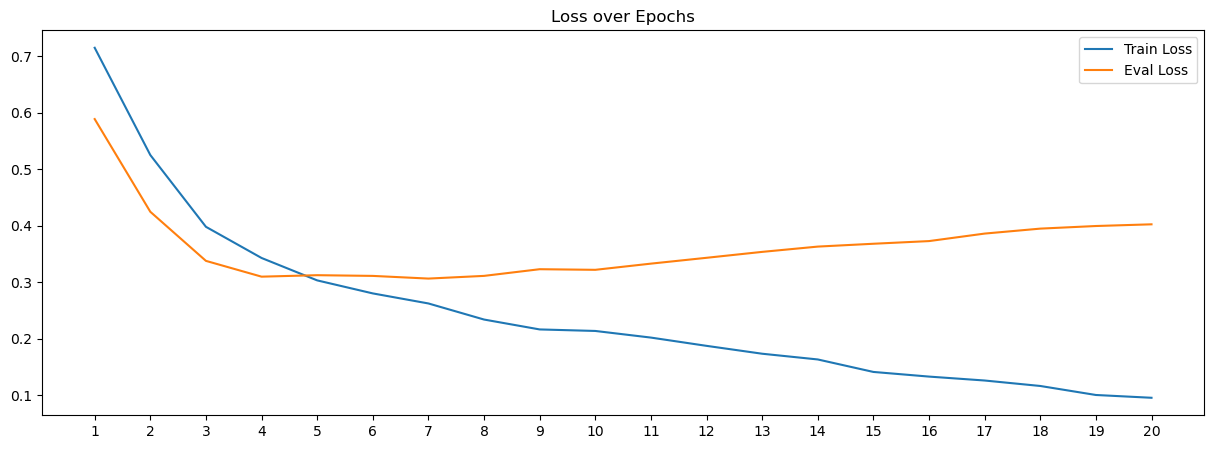

In [70]:
# Plotting training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(np.arange(1, 21, 1), epoch_train_loss, label='Train Loss')
plt.plot(np.arange(1, 21, 1), epoch_eval_loss, label='Eval Loss')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.title('Loss over Epochs')
plt.show();

### Загрузим лучшую сохраненную модель

In [72]:
#loading the best saved model
path = model.name_or_path.split('/')[1]+'.saved.weights.pt'
path

'rubert-tiny2.saved.weights.pt'

In [73]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [74]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

### Протестируем и сохраним результаты

In [76]:
get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/27 [00:00<?, ?it/s]

min_epoch: 7, epoch_time: 2.9775067925453187, total_train_time: 21.075112104415894, accuracy: 0.9016786570743405


[7, 2.98, 21.08, 0.9017]

In [77]:
results['ruBERT-tiny2'] = get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/27 [00:00<?, ?it/s]

min_epoch: 7, epoch_time: 2.9775067925453187, total_train_time: 21.075112104415894, accuracy: 0.9016786570743405


In [78]:
pd.DataFrame(results, index=['Epoch num','Epoch avg time','Total train time','Accuracy']).T

,Epoch num,Epoch avg time,Total train time,Accuracy
ruBERT-base,13.0,17.01,223.80,0.9209
ruBERT-tiny2,7.0,2.98,21.08,0.9017


## 2.3 BERT-base-multilingual-cased

In [80]:
base_model = 'google-bert/bert-base-multilingual-cased'

In [81]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer

BertTokenizerFast(name_or_path='google-bert/bert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [82]:
data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
data_tokenized

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1943
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 416
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 417
    })
})

In [83]:
print(data_tokenized['train'][0])

{'label': 2, 'input_ids': [101, 525, 46610, 16346, 10332, 10783, 25711, 117, 546, 10987, 10332, 10783, 27725, 117, 10122, 80465, 10648, 10122, 74132, 543, 11191, 10513, 117, 61381, 41794, 10517, 62416, 53513, 105190, 28501, 106, 27796, 15469, 61732, 86490, 40576, 10928, 31108, 119, 10405, 543, 13248, 31195, 13686, 18805, 526, 95927, 45224, 18005, 106, 106, 106, 549, 12265, 60189, 13323, 12252, 18494, 549, 12265, 55486, 78695, 11657, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [84]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [85]:
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True, batch_size=8, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['validation'], shuffle=False, batch_size=8, collate_fn=collator)
test_dataloader = DataLoader(data_tokenized['test'], shuffle=False, batch_size=8, collate_fn=collator)

In [86]:
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=3)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [87]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [88]:
optimizer = Adam(model.parameters(), lr=1e-6)  # with tiny batches, LR should be very small as well
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)

In [89]:
gc.collect()
torch.cuda.empty_cache()

In [90]:
# seting initial best loss to infinite
best_eval_loss = float('inf')

losses = []
epoch_train_loss = []
epoch_eval_loss = []
epoch_train_time = []
train_time = []
start = time.time()
for epoch in trange(20):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(out.loss.item())
        train_time.append(time.time() - start)
        pbar.set_description(f'loss: {np.mean(losses[-100:]):2.2f}')
    epoch_train_loss.append(np.mean(losses[-100:]))

    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    val_time = []
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
        val_time.append(time.time() - start)
    epoch_eval_loss.append(np.mean(eval_losses))
    epoch_train_time.append(elapsed := time.time() - start)
    val_loss = np.mean(eval_losses)
    print('Epoch:', epoch+1, 'Train Loss', np.mean(losses[-100:]), 'Eval Loss', val_loss, 'Accuracy', np.mean(np.array(eval_targets) == eval_preds), 'Time:', elapsed)

    #save the best model
    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        torch.save(model.state_dict(), model.name_or_path.split('/')[1]+'.saved.weights.pt')   

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1 Train Loss 0.644499189555645 Eval Loss 0.6133434660732746 Accuracy 0.7836538461538461 Time: 20.24451231956482


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2 Train Loss 0.5520945090055466 Eval Loss 0.5210364718849843 Accuracy 0.7836538461538461 Time: 42.01852869987488


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3 Train Loss 0.4781145016849041 Eval Loss 0.44205370702995705 Accuracy 0.7932692307692307 Time: 62.82499647140503


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4 Train Loss 0.421338954679668 Eval Loss 0.37555944425268817 Accuracy 0.8774038461538461 Time: 83.60353422164917


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5 Train Loss 0.3613384299352765 Eval Loss 0.3431771559855686 Accuracy 0.8966346153846154 Time: 104.47610878944397


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6 Train Loss 0.3135286014527082 Eval Loss 0.3579780192186053 Accuracy 0.8894230769230769 Time: 125.62158393859863


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 7 Train Loss 0.2836214710585773 Eval Loss 0.3369801208161964 Accuracy 0.8990384615384616 Time: 145.61705112457275


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 8 Train Loss 0.30205934001132845 Eval Loss 0.3411227909919734 Accuracy 0.8966346153846154 Time: 167.10485219955444


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 9 Train Loss 0.2602531627751887 Eval Loss 0.34838075903602517 Accuracy 0.8966346153846154 Time: 186.7894778251648


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 10 Train Loss 0.2581155120395124 Eval Loss 0.34138532516618186 Accuracy 0.8846153846153846 Time: 207.25467014312744


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 11 Train Loss 0.20655606565997003 Eval Loss 0.35199744214948553 Accuracy 0.8846153846153846 Time: 227.24194478988647


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 12 Train Loss 0.27144471265375614 Eval Loss 0.34143286930898636 Accuracy 0.8870192307692307 Time: 247.64603090286255


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 13 Train Loss 0.2160988803487271 Eval Loss 0.40292352285737604 Accuracy 0.8798076923076923 Time: 267.4577143192291


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 14 Train Loss 0.2081491289846599 Eval Loss 0.3725724537641956 Accuracy 0.8894230769230769 Time: 287.29987382888794


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 15 Train Loss 0.20790724054910242 Eval Loss 0.4274950924042899 Accuracy 0.8798076923076923 Time: 307.3240373134613


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 16 Train Loss 0.18853792020119728 Eval Loss 0.35424751265404314 Accuracy 0.8942307692307693 Time: 327.6057713031769


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 17 Train Loss 0.20329414169304072 Eval Loss 0.37361452766121006 Accuracy 0.8870192307692307 Time: 347.3286759853363


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 18 Train Loss 0.169213059367612 Eval Loss 0.3950092138077777 Accuracy 0.8822115384615384 Time: 367.2793810367584


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 19 Train Loss 0.19266387177631258 Eval Loss 0.3811782269487874 Accuracy 0.8822115384615384 Time: 387.3078029155731


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 20 Train Loss 0.1199518254213035 Eval Loss 0.3720859715070289 Accuracy 0.8846153846153846 Time: 407.1427183151245


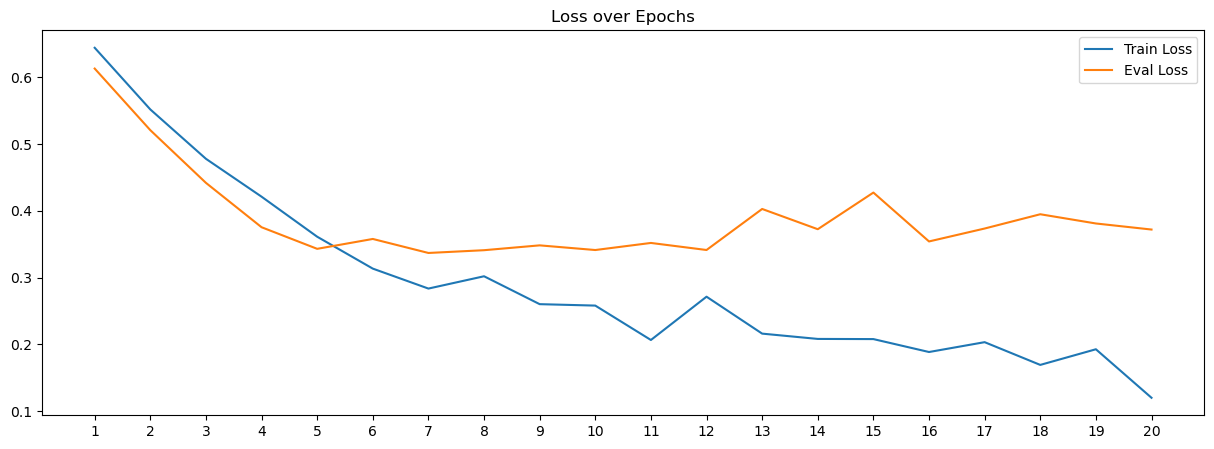

In [91]:
# Plotting training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(np.arange(1, 21, 1), epoch_train_loss, label='Train Loss')
plt.plot(np.arange(1, 21, 1), epoch_eval_loss, label='Eval Loss')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.title('Loss over Epochs')
plt.show();

### Загрузим лучшую сохраненную модель

In [93]:
#loading the best saved model
path = model.name_or_path.split('/')[1]+'.saved.weights.pt'
path

'bert-base-multilingual-cased.saved.weights.pt'

In [94]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [95]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

### Протестируем и сохраним результаты

In [97]:
results['bert-base-multilingual-cased'] = get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/53 [00:00<?, ?it/s]

min_epoch: 7, epoch_time: 20.357135915756224, total_train_time: 145.61705112457275, accuracy: 0.9016786570743405


In [98]:
pd.DataFrame(results, index=['Epoch num','Epoch avg time','Total train time','Accuracy']).T

,Epoch num,Epoch avg time,Total train time,Accuracy
ruBERT-base,13.0,17.01,223.80,0.9209
ruBERT-tiny2,7.0,2.98,21.08,0.9017
bert-base-multilingual-cased,7.0,20.36,145.62,0.9017


## 3. Анализ результатов

Итоговые результаты

In [101]:
pd.DataFrame(results, index = ['Epoch num','Epoch avg time','Total train time','Accuracy']).T.sort_values(by=['Accuracy'], ascending=False)

,Epoch num,Epoch avg time,Total train time,Accuracy
ruBERT-base,13.0,17.01,223.80,0.9209
ruBERT-tiny2,7.0,2.98,21.08,0.9017
bert-base-multilingual-cased,7.0,20.36,145.62,0.9017


- Впереди ожидаемо ruBert-base, специализированная модель для русского языка;
- Второе и третье места поделили ruBERT-tiny и мультиязычная модель от Google, что удивительно, учитывая на порядок меньший размер модели tiny$

На мой взгляд, из полученных результатов можно сделать следующий основной вывод - предобучение модели на целевом языке/корпусе текстов оказывает существенно большее влияние на результаты, нежели количество параметров модели.  